In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

import shap
import matplotlib.pyplot as plt

In [6]:
DATA_PATH = "customer_pd_dataset.csv"
df = pd.read_csv(DATA_PATH)

if "default_flag_v3" not in df.columns:
    df["default_flag_v3"] = np.where(
        (df["return_rate"] >= 0.40) |
        ((df["return_rate"] >= 0.20) & (df["total_profit"] < 0) & (df["avg_discount"] >= 0.30)),
        1, 0
    )

TARGET = "default_flag_v3"

print("Bad rate:", df[TARGET].mean())
df.head()


Bad rate: 0.053344817685902955


,total_orders,total_sales,total_profit,avg_discount,avg_shipping_delay,return_rate,customer_tenure_days,orders_per_year,default_flag,default_flag_v3
0,2,544.656,-153.0540,0.416667,3.333333,0.0,918,0.795207,0,0
1,1,2713.410,27.0900,0.000000,5.000000,0.0,0,1.000000,0,0
2,4,2955.798,514.6680,0.030769,2.692308,0.0,319,4.576803,0,0
3,2,4780.552,-650.5971,0.133333,5.000000,0.0,483,1.511387,0,0
4,2,753.508,274.4320,0.066667,4.333333,0.0,553,1.320072,0,0


In [7]:
leakage_features = [
    "return_rate",
    "avg_discount",
    "total_profit"
]

features = [
    c for c in df.columns
    if c != TARGET
    and pd.api.types.is_numeric_dtype(df[c])
    and c not in leakage_features
]

X = df[features].copy()
y = df[TARGET].astype(int).copy()

print("Features used:", features)


Features used: ['total_orders', 'total_sales', 'avg_shipping_delay', 'customer_tenure_days', 'orders_per_year', 'default_flag']


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train bad rate:", y_train.mean())
print("Test bad rate :", y_test.mean())


Train bad rate: 0.053330462245190925
Test bad rate : 0.053402239448751075


In [9]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    random_state=42
)


In [10]:
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [11]:
pd_test = xgb_model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, pd_test)
prauc = average_precision_score(y_test, pd_test)

print(f"XGBoost ROC-AUC: {auc:.4f}")
print(f"XGBoost PR-AUC : {prauc:.4f}")


XGBoost ROC-AUC: 0.6729
XGBoost PR-AUC : 0.3418


XGBoost KS: 0.3089


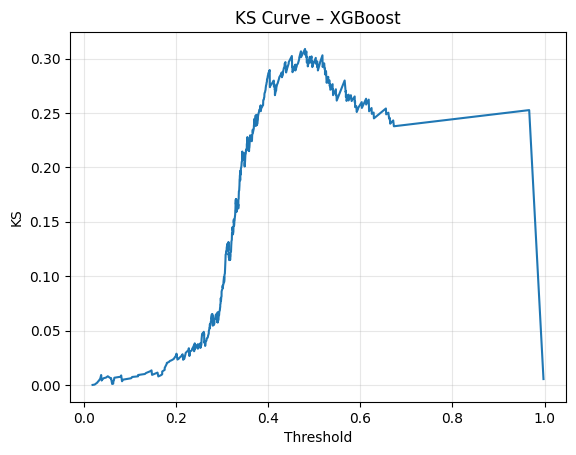

In [12]:
fpr, tpr, thresholds = roc_curve(y_test, pd_test)
ks = np.max(tpr - fpr)

print(f"XGBoost KS: {ks:.4f}")

plt.figure()
plt.plot(thresholds, tpr - fpr)
plt.title("KS Curve – XGBoost")
plt.xlabel("Threshold")
plt.ylabel("KS")
plt.grid(True, alpha=0.3)
plt.show()


In [13]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)


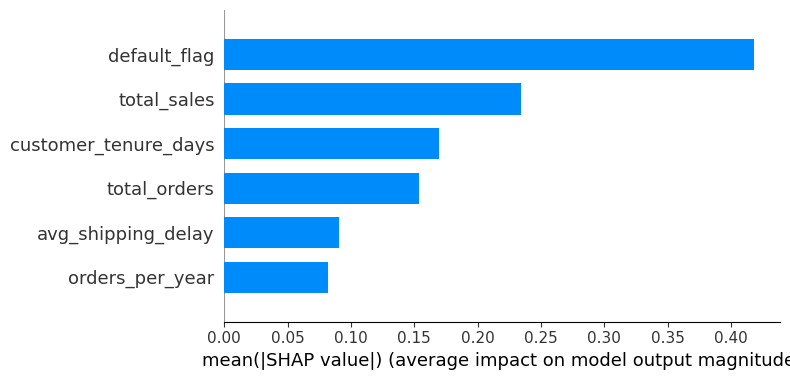

In [14]:
shap.summary_plot(
    shap_values,
    X_train,
    plot_type="bar",
    show=True
)


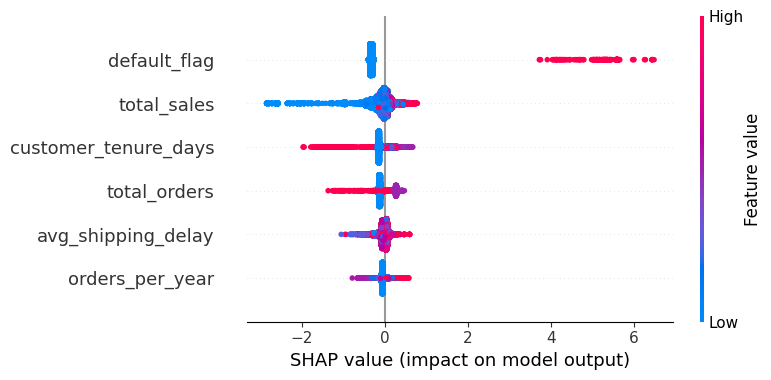

In [15]:
shap.summary_plot(
    shap_values,
    X_train,
    show=True
)


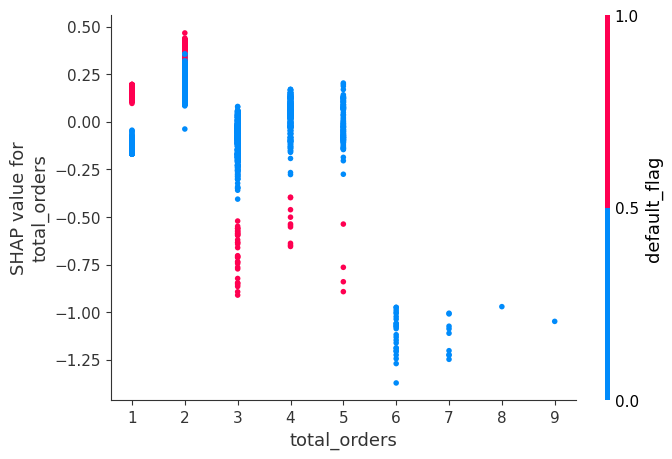

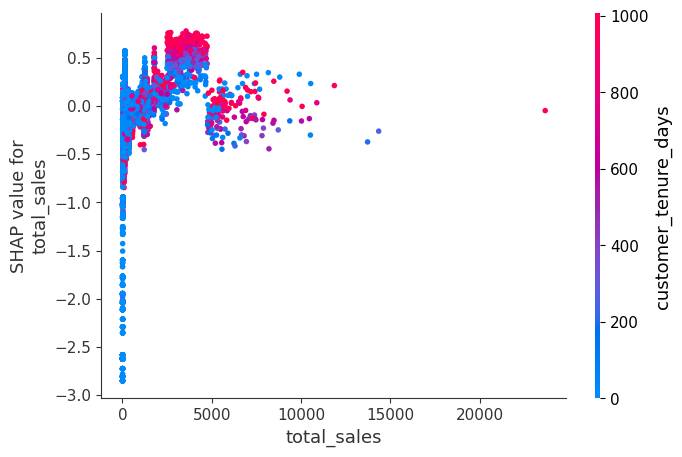

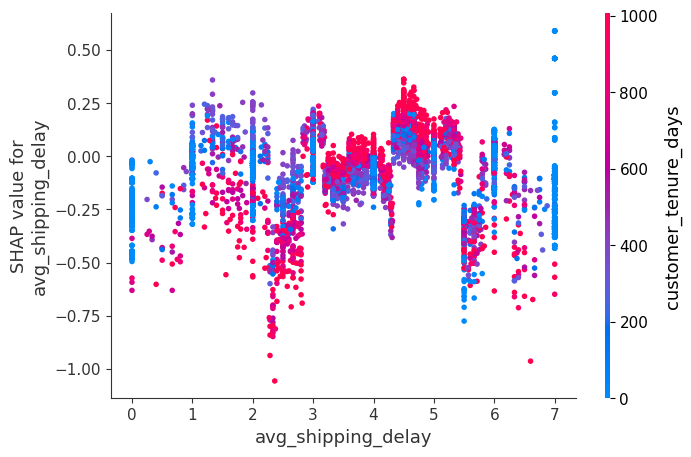

In [16]:
top_features = features[:3]  # replace with actual top features from summary

for f in top_features:
    shap.dependence_plot(f, shap_values, X_train)


In [19]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost"],
    "ROC-AUC": [0.6755, auc],
    "PR-AUC":  [0.3352, prauc]
})

comparison


,Model,ROC-AUC,PR-AUC
0,Logistic Regression,0.675500,0.335200
1,XGBoost,0.672935,0.341771
